In [1]:
:extension NoMonomorphismRestriction FlexibleContexts TypeFamilies
import Control.Monad
import Control.Monad.State

import System.Random
import Data.Random
import Data.Random.Distribution.Pareto
import Data.RVar

import Diagrams.Prelude hiding (normal)
import Data.Colour.Palette.BrewerSet
import qualified Diagrams.Color.XKCD as XKCD
import Data.Colour (withOpacity)

In [16]:
randomNormal :: (Num a, Distribution Normal a) => RVar a
randomNormal = normal 0 1

randomPareto :: (Floating a, Distribution StdUniform a) => RVar a
randomPareto = pareto 1 1

randomVariable :: (Floating b, Distribution StdUniform b, Distribution Normal b)
                   => RVarT Identity b
randomVariable = (*) <$> randomPareto <*> randomNormal

sampleNormal :: State StdGen Double
sampleNormal = sampleRVar randomNormal

sampleVariable = sampleRVar randomVariable

evalState sampleNormal $ mkStdGen 1
evalState sampleVariable $ mkStdGen 1

-1.139167836612823

-0.10940815185138648

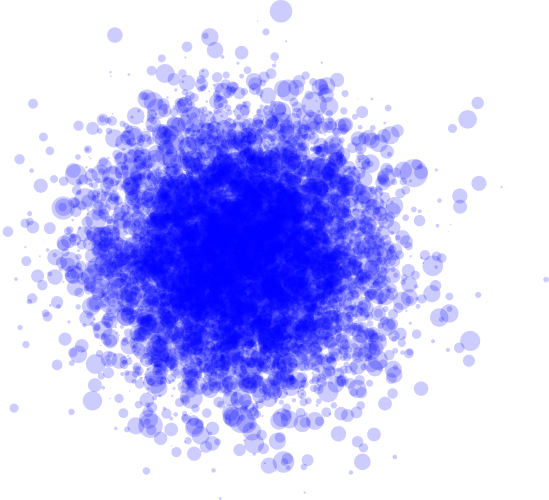

In [8]:
bubble r = circle r # lw none # fcA (blue `withOpacity` 0.2)

-- RVarT Identity b
randBubbles n = do
  rs <- replicateM n $ normal 1 1
  xs <- replicateM n $ normal 0 20
  ys <- replicateM n $ normal 0 20
  let points = map p2 $ zip xs ys
      bubbles  = map bubble rs
  return $ position (zip points bubbles)
          
-- (MonadRandom m, ...) m a
sampleBubbles n = sampleRVar $ randBubbles n

withImgHeight 500 $ diagram $ evalState (sampleBubbles 9000) $ mkStdGen 1

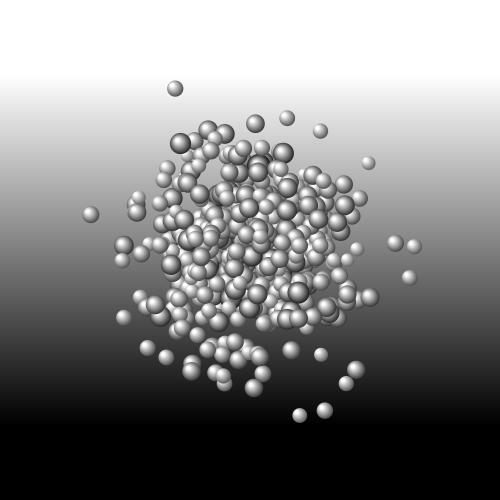

In [6]:
radial = mkRadialGradient (mkStops [(white,0,1), (black,1,1)])
                          ((-0.15) ^& (0.15)) 0.06 (0 ^& 0) 0.5
                          GradPad

linear = mkLinearGradient (mkStops [(black,0,1), (white,1,1)])
                          (0 ^& (-7)) (0 ^& 7)
                          GradPad
                          
pearl r = circle r # fillTexture radial # lw none

-- RVarT Identity b
randPearls n = do
  rs <- replicateM n $ normal 0.35 0.04
  xs <- replicateM n $ normal 0 2
  ys <- replicateM n $ normal 0 2
  let points = map p2 $ zip xs ys
      pearls  = map pearl rs
  return $ position (zip points pearls)
          
-- (MonadRandom m, ...) m a
samplePearls n = sampleRVar $ randPearls n

diagramPearls n = evalState (samplePearls n) $ mkStdGen 1

withImgHeight 500 $ diagram $ diagramPearls 500 <> rect 20 20 # fillTexture linear # lw none

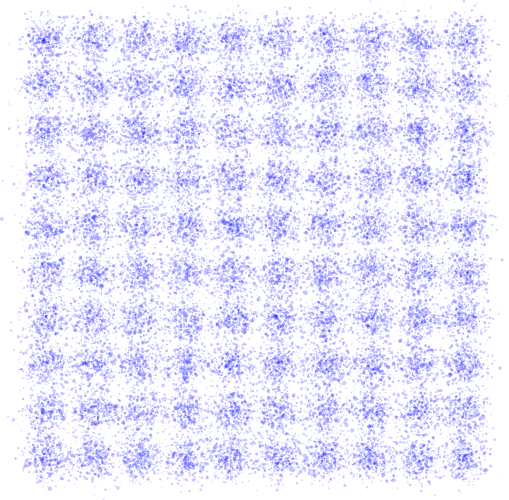

In [16]:
randBubbleSheet k n = do
  grid <- replicateM k $ replicateM k $ randBubbles n
  return $ hcat' distrib $ map (vcat' distrib) grid
    where distrib = (with & catMethod .~ Distrib & sep .~ 80)
  
sampleBubbleSheet k n = sampleRVar $ randBubbleSheet k n

withImgHeight 500 $ diagram $ evalState (sampleBubbleSheet 10 600) $ mkStdGen 1

## Lines

In [43]:
randomLine width var = replicateM width $ normal 0.0 var

drawLine line = (cubicSpline False (map p2 $ zip [0,1..] line)) # lcA (blue `withOpacity` 0.2)
                                                           # lw 2
                                                             
walkingLine n width var = do
  steps <- replicateM n $ randomLine width var
  let walk = scanl1 (zipWith (+)) steps
  return $ mconcat $ map drawLine walk
  
sampleAndDraw seed randomDiagram = withImgHeight 500 $ diagram $ d
  where d = evalState (sampleRVar randomDiagram) $ mkStdGen seed

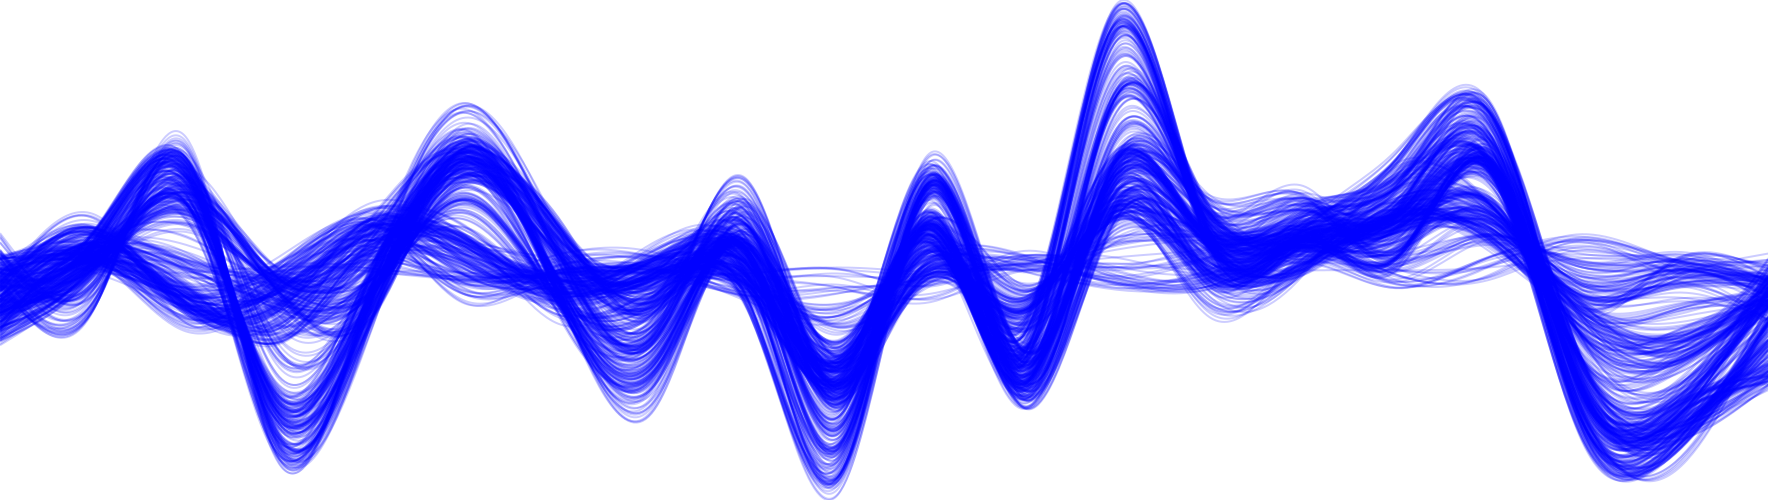

In [45]:
sampleAndDraw 2 $ walkingLine 500 20 0.05